In [1]:
from utils.dataloader import FifaStatDatabase
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

In [3]:
db = FifaStatDatabase('FifaStat.sqlite')

# Q1

In [ ]:
db.get_all_tables()

In [ ]:
df_match_denorm = db.execute_query_df("""
    SELECT m.season, m.home_team_goal, m.away_team_goal, l.name as league_name, c.name as country_name, 
           t_home.team_long_name as home_team_name, t_away.team_long_name as away_team_name
    FROM Match m
    LEFT JOIN League l ON m.league_id = l.id
    LEFT JOIN Country c ON m.country_id = c.id
    LEFT JOIN Team t_home ON m.home_team_api_id = t_home.team_api_id
    LEFT JOIN Team t_away ON m.away_team_api_id = t_away.team_api_id
""")
df_match_denorm

In [ ]:
df_match_denorm['WinLossDraw'] = df_match_denorm.apply(lambda x: 'Home Win' if x['home_team_goal'] > x['away_team_goal'] else ('Away Win' if x['home_team_goal'] < x['away_team_goal'] else 'Draw'), axis=1)
df_match_denorm['WinLossDraw'].value_counts() / df_match_denorm['WinLossDraw'].count() * 100

In [ ]:
# Nan verify
df_match_denorm.isna().sum()

In [ ]:
# Calculate home and away win rates by team
team_stats = pd.DataFrame()

# Home win rates
home_wins = df_match_denorm[df_match_denorm['WinLossDraw']
                            == 'Home Win']['home_team_name'].value_counts()
home_total = df_match_denorm['home_team_name'].value_counts()
home_win_rates = (home_wins / home_total).fillna(0)

# Away win rates
away_wins = df_match_denorm[df_match_denorm['WinLossDraw']
                            == 'Away Win']['away_team_name'].value_counts()
away_total = df_match_denorm['away_team_name'].value_counts()
away_win_rates = (away_wins / away_total).fillna(0)

# Create dataframe for plotting
team_stats['home_win_rate'] = home_win_rates
team_stats['away_win_rate'] = away_win_rates

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))

# Add y=x line
plt.plot([0, 1], [0, 1], '--', color='gray', alpha=0.5)

# Create scatter plot with team names
sns.scatterplot(data=team_stats, x='home_win_rate', y='away_win_rate')

# Add team names as annotations
# for idx in team_stats.index:
#     plt.annotate(idx,
#                  (team_stats.loc[idx, 'home_win_rate'],
#                   team_stats.loc[idx, 'away_win_rate']),
#                  xytext=(5, 5), textcoords='offset points',
#                  fontsize=6)

plt.title('Home vs Away Win Rates by Team')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Home Win Rate')
plt.ylabel('Away Win Rate')

In [ ]:
plt.figure(figsize=(12, 7))

# # Set style
# plt.style.use('seaborn')

# Create KDE plots with better colors and styling
sns.histplot(data=team_stats['home_win_rate'], label='Home Win Rate',
             bins=25, fill=True, alpha=0.6, kde=True, linewidth=0.5)
sns.histplot(data=team_stats['away_win_rate'], label='Away Win Rate',
             bins=25, fill=True, alpha=0.6, kde=True, linewidth=0.5)

# Customize the plot
plt.title('Distribution of Home vs Away Win Rates', fontsize=14, pad=15)
plt.xlabel('Win Rate', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Customize legend
plt.legend(frameon=True, facecolor='white', framealpha=1, fontsize=10)

# Add grid and customize its appearance
plt.grid(True, alpha=0.3, linestyle='--')

# Set x-axis limits for better visualization
plt.xlim(0, 0.8)

# Remove top and right spines
sns.despine()

# Adjust layout
plt.tight_layout()

In [ ]:
from scipy import stats

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(team_stats['home_win_rate'], team_stats['away_win_rate'])

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4e}")
# Check if the difference is statistically significant at α = 0.05
if p_value < 0.05:
    print("There is a statistically significant difference between home and away win rates")
else:
    print("No significant difference between home and away win rates")
print("\nMedian win rates:")
print(f"Home: {team_stats['home_win_rate'].median():.4f}")
print(f"Away: {team_stats['away_win_rate'].median():.4f}")

In [ ]:
# Calculate the percentage of each outcome per season
season_outcomes = pd.crosstab(df_match_denorm['season'], df_match_denorm['WinLossDraw'], normalize='index') * 100

# Create a bar plot
plt.figure(figsize=(12, 6))
season_outcomes.iloc[2:, :].plot(kind='bar', stacked=False)

plt.title('Match Outcomes by Season')
plt.xlabel('Season')
plt.ylabel('Percentage of Matches (%)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add legend
plt.legend(title='Match Outcome')

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [ ]:
# Calculate win/loss/draw rates for each league
league_outcomes = pd.crosstab(df_match_denorm['league_name'], 
                            df_match_denorm['WinLossDraw'], 
                            normalize='index') * 100

# Create a bar plot
plt.figure(figsize=(15, 8))
league_outcomes.plot(kind='bar', stacked=False)

plt.title('Match Outcomes by League', fontsize=12, pad=15)
plt.xlabel('League', fontsize=10)
plt.ylabel('Percentage of Matches (%)', fontsize=10)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(title='Match Outcome', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [ ]:
# Create pivot table for league performance by season
league_season_data = df_match_denorm.pivot_table(
    index='league_name',
    columns='season',
    values='WinLossDraw',
    aggfunc=lambda x: (x == 'Home Win').mean() * 100
)

league_season_data = league_season_data.iloc[:, 2:]

# Create the plot
plt.figure(figsize=(15, 8))

# Plot lines for each league
for league in league_season_data.index:
    plt.plot(league_season_data.columns,
             league_season_data.loc[league],
             marker='o',
             label=league)

# Calculate and plot overall season averages
season_averages = league_season_data.mean()
plt.plot(league_season_data.columns, 
         season_averages, 
         'k:',  # black dotted line
         linewidth=2, 
         label='Overall Average')

# Customize the plot
plt.title('League Performance Across Seasons', fontsize=14, pad=15)
plt.xlabel('Season', fontsize=12)
plt.ylabel('Home Win Rate (%)', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend with better positioning
plt.legend(title='League', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add grid for better readability
plt.grid(True, alpha=0.3, linestyle='--')

plt.ylim(0, 100)  # Set y-axis limits for better visualization

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Q2

In [108]:
df_match_denorm = db.execute_query_df("""
    SELECT m.*, l.name as league_name, c.name as country_name, 
           t_home.team_long_name as home_team_name, t_away.team_long_name as away_team_name
           
    FROM Match m
    LEFT JOIN League l ON m.league_id = l.id
    LEFT JOIN Country c ON m.country_id = c.id
    LEFT JOIN Team t_home ON m.home_team_api_id = t_home.team_api_id
    LEFT JOIN Team t_away ON m.away_team_api_id = t_away.team_api_id
    
    WHERE m.home_player_1 IS NOT NULL
    OR m.home_player_2 IS NOT NULL
    OR m.home_player_3 IS NOT NULL
    OR m.home_player_4 IS NOT NULL
    OR m.home_player_5 IS NOT NULL
    OR m.home_player_6 IS NOT NULL
    OR m.home_player_7 IS NOT NULL
    OR m.home_player_8 IS NOT NULL
    OR m.home_player_9 IS NOT NULL
    OR m.home_player_10 IS NOT NULL
    OR m.home_player_11 IS NOT NULL
    OR m.away_player_1 IS NOT NULL
    OR m.away_player_2 IS NOT NULL
    OR m.away_player_3 IS NOT NULL
    OR m.away_player_4 IS NOT NULL
    OR m.away_player_5 IS NOT NULL
    OR m.away_player_6 IS NOT NULL
    OR m.away_player_7 IS NOT NULL
    OR m.away_player_8 IS NOT NULL
    OR m.away_player_9 IS NOT NULL
    OR m.away_player_10 IS NOT NULL
    OR m.away_player_11 IS NOT NULL 
""")

In [109]:
df_match_denorm.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,...,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
count,25221.000000,25221.000000,25221.000000,25221.000000,2.522100e+04,25221.000000,25221.000000,25221.000000,25221.000000,24158.000000,24158.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.00000,24147.000000,24147.000000,24147.000000,24146.000000,24146.000000,24140.000000,24158.000000,24158.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.00000,24147.000000,24147.0,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,24147.000000,...,24698.000000,24656.000000,24663.000000,24654.000000,24752.000000,24670.000000,24706.000000,24543.000000,24424.000000,24745.000000,24701.000000,24686.000000,24658.000000,24644.000000,24666.000000,24744.000000,24638.000000,24651.000000,24538.000000,24425.000000,22077.000000,22077.000000,22077.000000,22060.000000,22060.000000,22060.000000,22005.000000,22005.000000,22005.000000,22041.000000,22041.000000,22041.000000,11168.000000,11168.000000,11168.000000,22062.000000,22062.000000,22062.000000,16582.000000,16582.000000,16582.000000,22055.000000,22055.000000,22055.000000,13647.000000,13647.000000,13647.000000,13647.000000,13647.000000,13647.000000
mean,13009.524285,11724.110265,11724.110265,18.449467,1.216118e+06,10022.146307,10023.220015,1.544031,1.163396,0.999586,2.073516,4.061001,6.049199,7.544871,3.185158,4.769909,5.309604,5.822048,5.389407,5.783244,1.000290,2.074585,4.058558,6.052222,7.52549,3.195387,4.742660,5.294115,5.807546,5.476187,5.766114,0.999627,2.998634,3.000083,3.000414,3.237214,6.476954,6.672257,7.238953,8.026339,9.218868,10.43699,1.000248,3.0,3.000166,3.000248,3.245124,6.469706,6.680292,7.246366,...,91601.289457,94540.204494,109527.842071,102308.768516,97287.636918,107290.992947,111131.536914,105612.508373,103413.870660,76628.199879,107614.617424,91126.781293,95083.910617,109800.936901,102308.262588,97898.056014,109265.114214,111087.003448,107149.115943,104932.876970,2.633457,3.842918,4.665912,2.563398,3.751073,4.399374,2.472670,3.612518,4.155805,2.541893,3.716330,4.390911,2.816447,4.132324,4.972744,2.584985,3.668159,4.491625,2.570795,3.759132,4.625207,2.675675,3.906345,4.855154,2.503941,3.650651,4.357557,2.503528,3.663697,4.410953
std,7474.830938,7530.854614,7530.854614,10.435298,4.871648e+05,14291.515315,14291.569857,1.297383,1.142080,0.022284,0.387185,0.385973,0.446024,1.609682,1.233609,1.092386,1.687376,1.968550,1.492068,0.759585,0.033438,0.403572,0.387047,0.448413,1.63765,1.284060,1.118226,1.687324,1.957116,1.541351,0.763611,0.024916,0.064003,0.012871,0.028777,0.940481,0.739988,0.588560,0.588947,1.126462,1.073893,0.50578,0.022292,0.0,0.025741,0.028779,0.955398,0.756391,0.586502,0.579881,...,102703.003558,102789.967205,112787.542376,111514.726490,1070

In [110]:

player_match_dicts = []

for i in range(1, 12):
    df_match_denorm_copy = df_match_denorm.dropna(
        subset=[f'home_player_{i}', f'home_player_X{i}', f'home_player_Y{i}'], how='any').copy()
    # Process home players
    home_df = df_match_denorm_copy[[
        f'home_player_{i}', f'home_player_X{i}', f'home_player_Y{i}', 'date', 'id', 'league_name']]
    player_match_dicts += home_df.apply(
        lambda x: {
            "id": x[f'home_player_{i}'],
            "position_x": x[f'home_player_X{i}'],
            "position_y": x[f'home_player_Y{i}'],
            "team": "home",
            "date": x['date'],
            "match_id": x['id'],
            "league_name": x['league_name'],
        }, axis=1
    ).tolist()

for i in range(1, 12):
    df_match_denorm_copy = df_match_denorm.dropna(
        subset=[f'away_player_{i}', f'away_player_X{i}', f'away_player_Y{i}'], how='any').copy()
    # Process away players
    away_df = df_match_denorm_copy[[
        f'away_player_{i}', f'away_player_X{i}', f'away_player_Y{i}', 'date', 'id', 'league_name']]
    player_match_dicts += away_df.apply(
        lambda x: {
            "id": x[f'away_player_{i}'],
            "position_x": x[f'away_player_X{i}'],
            "position_y": x[f'away_player_Y{i}'],  
            "team": "away",
            "date": x['date'],
            "match_id": x['id'],
            "league_name": x['league_name'],
        }, axis=1
    ).tolist()

# Convert to DataFrame
player_match_df = pd.DataFrame(player_match_dicts)
player_match_df['date'] = pd.to_datetime(player_match_df['date'])
player_match_df

,id,position_x,position_y,team,date,match_id,league_name
0,39890.0,1.0,1.0,home,2009-02-28,145,Belgium Jupiler League
1,38327.0,1.0,1.0,home,2009-02-27,146,Belgium Jupiler League
2,95597.0,1.0,1.0,home,2009-02-28,147,Belgium Jupiler League
3,30934.0,1.0,1.0,home,2009-03-01,149,Belgium Jupiler League
4,37990.0,1.0,1.0,home,2009-02-28,150,Belgium Jupiler League
...,...,...,...,...,...,...,...
527613,289732.0,5.0,11.0,away,2015-09-22,25975,Switzerland Super League
527614,95257.0,7.0,10.0,away,2015-09-23,25976,Switzerland Super League
527615,275122.0,5.0,11.0,away,2015-09-23,25977,Switzerland Super League
527616,194532.0,5.0,11.0,away,2015-09-22,25978,Switzerland Super League


In [111]:
# Dictionary to cache player data
_player_cache = {}

def get_height_weight_bmi(player_id):
    # Check if player data is already in cache
    if player_id in _player_cache:
        height, weight, bmi = _player_cache[player_id]
        return height, weight, bmi
    
    # Query the Player table for height and weight if not in cache
    query = f"""
        SELECT height, weight
        FROM Player
        WHERE player_api_id = {player_id}
    """
    result = db.execute_query(query)
    
    if result:
        height = result[0][0]  # Get the first row's first column (height)
        weight = result[0][1]  # Get the first row's second column (weight)
        # Convert weight from pounds to kg if it's in pounds (assuming weights over 100 are in pounds)
        weight = weight / 2.20462
        
        # Check if both height and weight exist
        if height and weight:
            # Calculate BMI
            height_m = height / 100  # Convert cm to m
            bmi = weight / (height_m ** 2)
            # Cache the results
            _player_cache[player_id] = (height, weight, bmi)
            return height, weight, bmi
            
    # Cache null results too to avoid repeated database queries
    _player_cache[player_id] = (None, None, None)
    return None, None, None

# Apply the function to get height, weight, and BMI for each player
player_match_df['height'], player_match_df['weight'], player_match_df['bmi'] = zip(*player_match_df['id'].apply(get_height_weight_bmi))
del _player_cache  # Clear the cache to free up memory

player_match_df.describe()

,id,position_x,position_y,date,match_id,height,weight,bmi
count,527618.000000,527618.000000,527618.000000,527618,527618.000000,527618.000000,527618.000000,527618.000000
mean,101313.801375,4.635270,5.568394,2012-09-03 07:27:21.219215104,12847.331808,182.091433,76.940006,23.179087
min,2625.000000,0.000000,0.000000,2008-08-09 00:00:00,145.000000,157.480000,53.070370,17.589600
25%,31047.000000,3.000000,3.000000,2010-10-16 00:00:00,6235.000000,177.800000,72.121273,22.373263
50%,41432.000000,5.000000,6.000000,2012-10-07 00:00:00,12246.000000,182.880000,77.110795,23.220190
75%,150731.000000,6.000000,8.000000,2014-09-27 00:00:00,19841.000000,187.960000,81.193131,24.009161
max,750584.000000,9.000000,11.000000,2016-05-25 00:00:00,25979.000000,208.280000,110.223077,30.865764
std,109706.284795,2.173393,2.994650,NaN,7603.842226,6.367293,6.817707,1.312298


In [112]:
from tqdm import tqdm

# Sort the player attributes table database by date
player_attributes_df = db.execute_query_df("""
    SELECT player_api_id, date, overall_rating
    FROM Player_Attributes
    ORDER BY date DESC
""")

# convert date column to datetime
player_attributes_df['date'] = pd.to_datetime(player_attributes_df['date'])

# Create a dictionary for fast lookups
# Key: player_id, Value: dataframe with that player's records (already sorted by date descending)
player_ratings_dict = {player_id: group for player_id,
                      group in player_attributes_df.groupby('player_api_id')}

# Vectorized function for batch processing with progress bar
def get_overall_ratings(player_ids, dates):
    ratings = []
    
    # Using tqdm to show progress
    for player_id, date in tqdm(zip(player_ids, dates), 
                               total=len(player_ids), 
                               desc="Processing player ratings"):
        if player_id in player_ratings_dict:
            player_df = player_ratings_dict[player_id]
            # Find the most recent rating before the match date
            mask = player_df['date'] <= date
            valid_ratings = player_df[mask]
            if not valid_ratings.empty:
                ratings.append(valid_ratings.iloc[0]['overall_rating'])
            else:
                ratings.append(None)
        else:
            ratings.append(None)

    return ratings

# Apply the optimized function to get overall ratings in a single batch operation
player_match_df['overall_rating'] = get_overall_ratings(
    player_match_df['id'].values,
    player_match_df['date'].values
)
player_match_df['overall_rating'].describe()

Processing player ratings: 100%|██████████| 527618/527618 [02:44<00:00, 3209.48it/s]


count    527618.000000
mean         71.362592
std           6.801348
min          35.000000
25%          67.000000
50%          72.000000
75%          76.000000
max          94.000000
Name: overall_rating, dtype: float64

In [113]:
# Check for players in each match
player_match_df.groupby('match_id').size().reset_index(name='count').describe()

,match_id,count
count,24158.000000,24158.000000
mean,12861.023595,21.840301
std,7602.899946,0.644357
min,145.000000,1.000000
25%,6248.250000,22.000000
50%,12287.500000,22.000000
75%,19835.750000,22.000000
max,25979.000000,22.000000


In [114]:
# Get basic statistics for each player
player_match_df.describe()

,id,position_x,position_y,date,match_id,height,weight,bmi,overall_rating
count,527618.000000,527618.000000,527618.000000,527618,527618.000000,527618.000000,527618.000000,527618.000000,527618.000000
mean,101313.801375,4.635270,5.568394,2012-09-03 07:27:21.219215104,12847.331808,182.091433,76.940006,23.179087,71.362592
min,2625.000000,0.000000,0.000000,2008-08-09 00:00:00,145.000000,157.480000,53.070370,17.589600,35.000000
25%,31047.000000,3.000000,3.000000,2010-10-16 00:00:00,6235.000000,177.800000,72.121273,22.373263,67.000000
50%,41432.000000,5.000000,6.000000,2012-10-07 00:00:00,12246.000000,182.880000,77.110795,23.220190,72.000000
75%,150731.000000,6.000000,8.000000,2014-09-27 00:00:00,19841.000000,187.960000,81.193131,24.009161,76.000000
max,750584.000000,9.000000,11.000000,2016-05-25 00:00:00,25979.000000,208.280000,110.223077,30.865764,94.000000
std,109706.284795,2.173393,2.994650,NaN,7603.842226,6.367293,6.817707,1.312298,6.801348


C:\Users\KOSEN\AppData\Local\Temp\ipykernel_16764\376132164.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Team', loc='upper right')


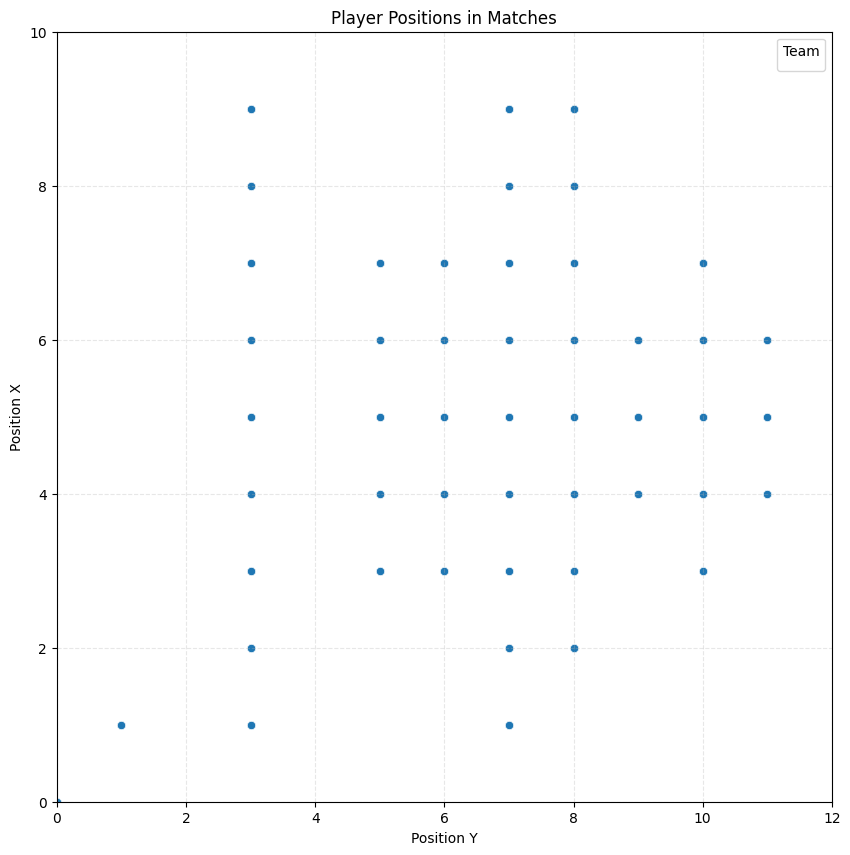

In [115]:
# scatter plot of position x and y
plt.figure(figsize=(10, 10))
sns.scatterplot(data=player_match_df, x='position_y', y='position_x')
plt.title('Player Positions in Matches')
plt.xlabel('Position Y')
plt.ylabel('Position X')
plt.xlim(0, 12)
plt.ylim(0, 10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(title='Team', loc='upper right')
plt.show()

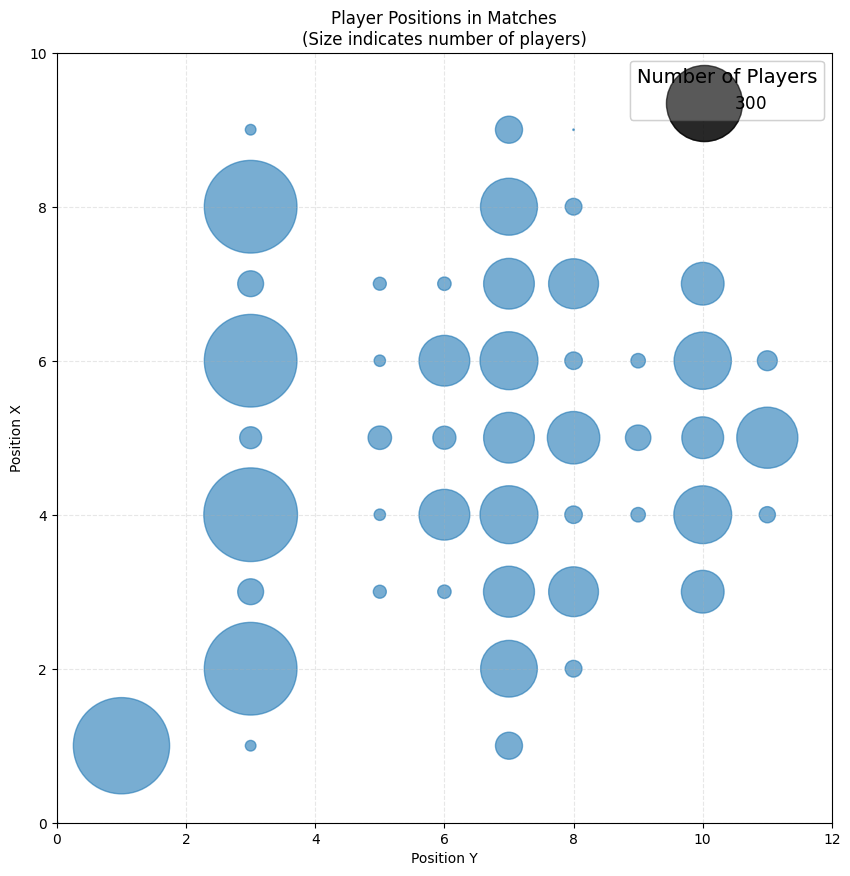

In [116]:
# Count number of players in each position combination
position_counts = player_match_df.groupby(['position_x', 'position_y']).size().reset_index(name='count')

plt.figure(figsize=(10, 10))
# Use size parameter to scale the points based on count
scatter = plt.scatter(position_counts['position_y'], 
                     position_counts['position_x'], 
                     s=position_counts['count']/10, # multiply by 2 to make points more visible
                     alpha=0.6)

plt.title('Player Positions in Matches\n(Size indicates number of players)')
plt.xlabel('Position Y')
plt.ylabel('Position X')
plt.xlim(0, 12)
plt.ylim(0, 10)
plt.grid(True, alpha=0.3, linestyle='--')

# Add a legend showing the scale
legend1 = plt.legend(*scatter.legend_elements(prop="sizes", alpha=0.6, 
                                            num=1, 
                                            func=lambda s: s/10), # divide by 10 to show actual counts
                    loc="upper right", 
                    title="Number of Players",
                    fontsize=12,
                    title_fontsize=14)
plt.gca().add_artist(legend1)

plt.show()

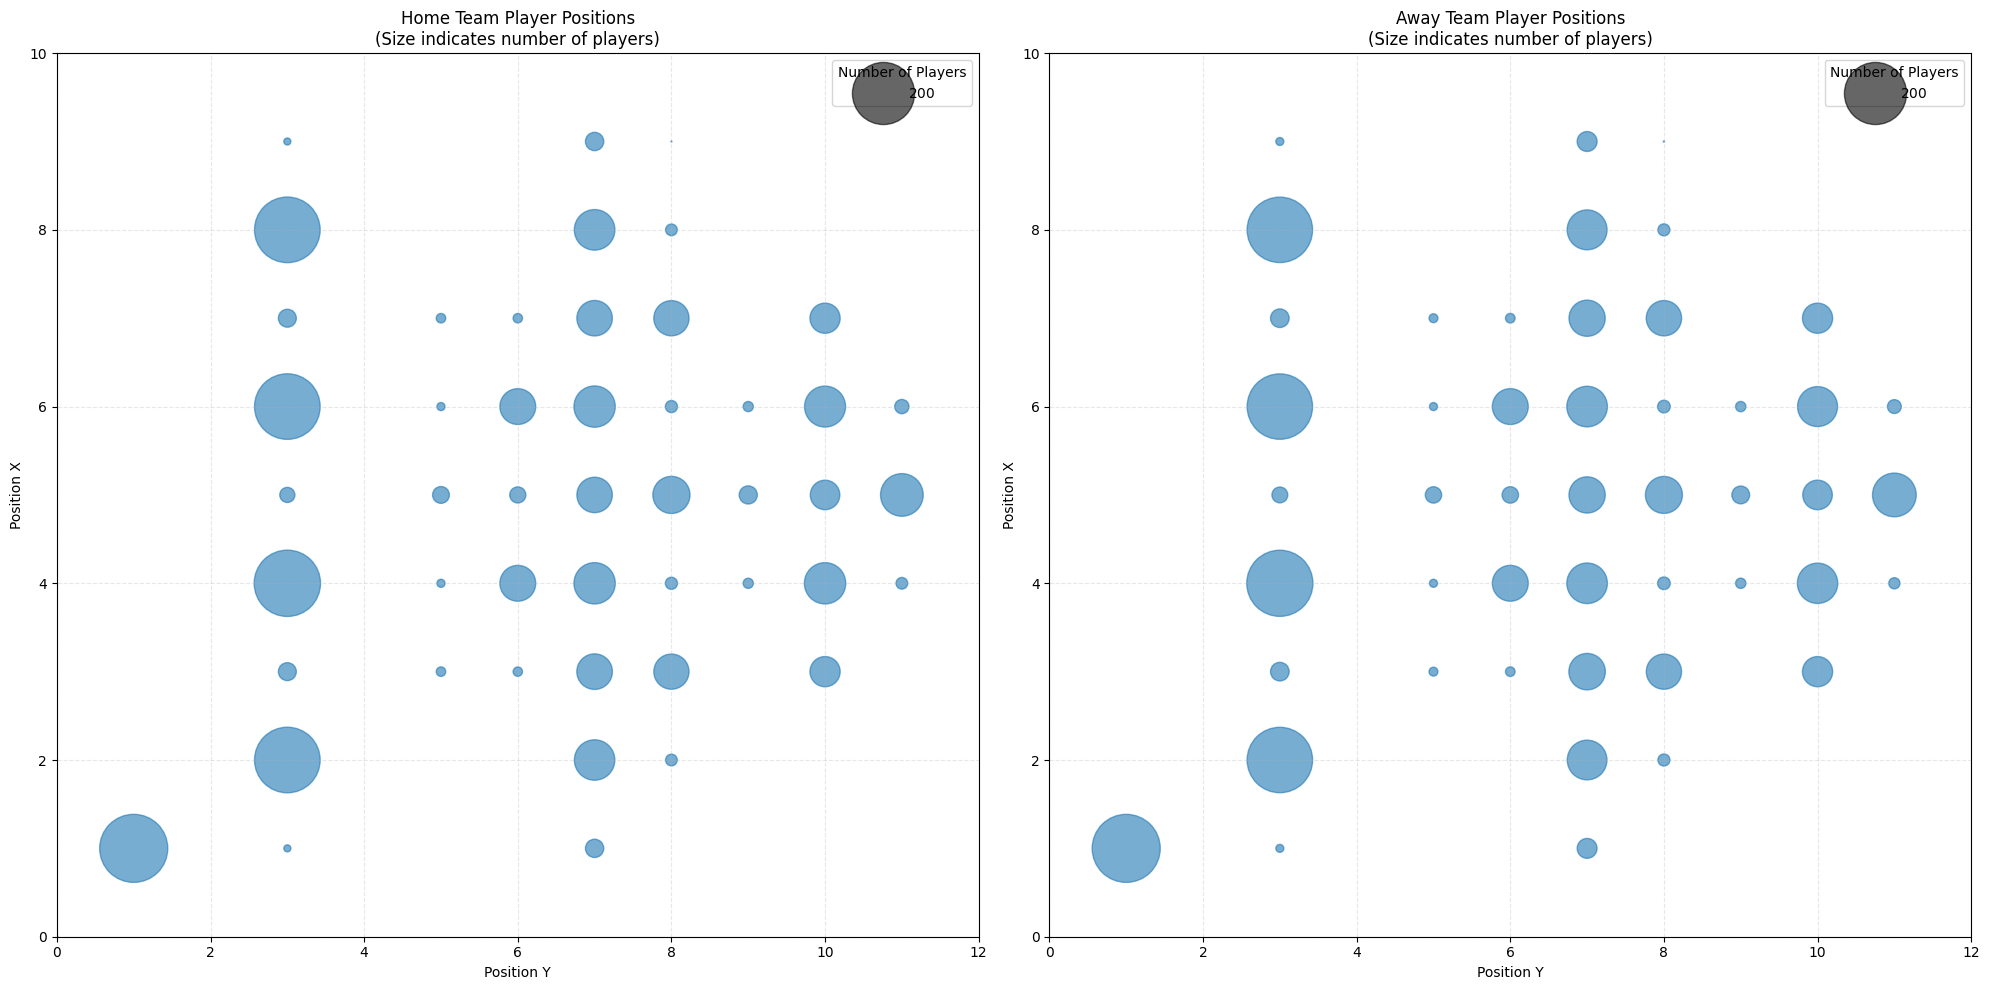

In [117]:
# Split data by team
home_positions = position_counts = player_match_df[player_match_df['team'] == 'home'].groupby(['position_x', 'position_y']).size().reset_index(name='count')
away_positions = position_counts = player_match_df[player_match_df['team'] == 'away'].groupby(['position_x', 'position_y']).size().reset_index(name='count')

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot home team positions
scatter1 = ax1.scatter(home_positions['position_y'], 
                      home_positions['position_x'], 
                      s=home_positions['count']/10,
                      alpha=0.6)
ax1.set_title('Home Team Player Positions\n(Size indicates number of players)')
ax1.set_xlabel('Position Y')
ax1.set_ylabel('Position X')
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 10)
ax1.grid(True, alpha=0.3, linestyle='--')

# Plot away team positions
scatter2 = ax2.scatter(away_positions['position_y'], 
                      away_positions['position_x'], 
                      s=away_positions['count']/10,
                      alpha=0.6)
ax2.set_title('Away Team Player Positions\n(Size indicates number of players)')
ax2.set_xlabel('Position Y')
ax2.set_ylabel('Position X')
ax2.set_xlim(0, 12)
ax2.set_ylim(0, 10)
ax2.grid(True, alpha=0.3, linestyle='--')

# Add legends
legend1 = ax1.legend(*scatter1.legend_elements(prop="sizes", alpha=0.6, 
                                             num=1, 
                                             func=lambda s: s/10),
                    loc="upper right", 
                    title="Number of Players")

legend2 = ax2.legend(*scatter2.legend_elements(prop="sizes", alpha=0.6, 
                                             num=1, 
                                             func=lambda s: s/10),
                    loc="upper right", 
                    title="Number of Players")

plt.tight_layout()
plt.show()

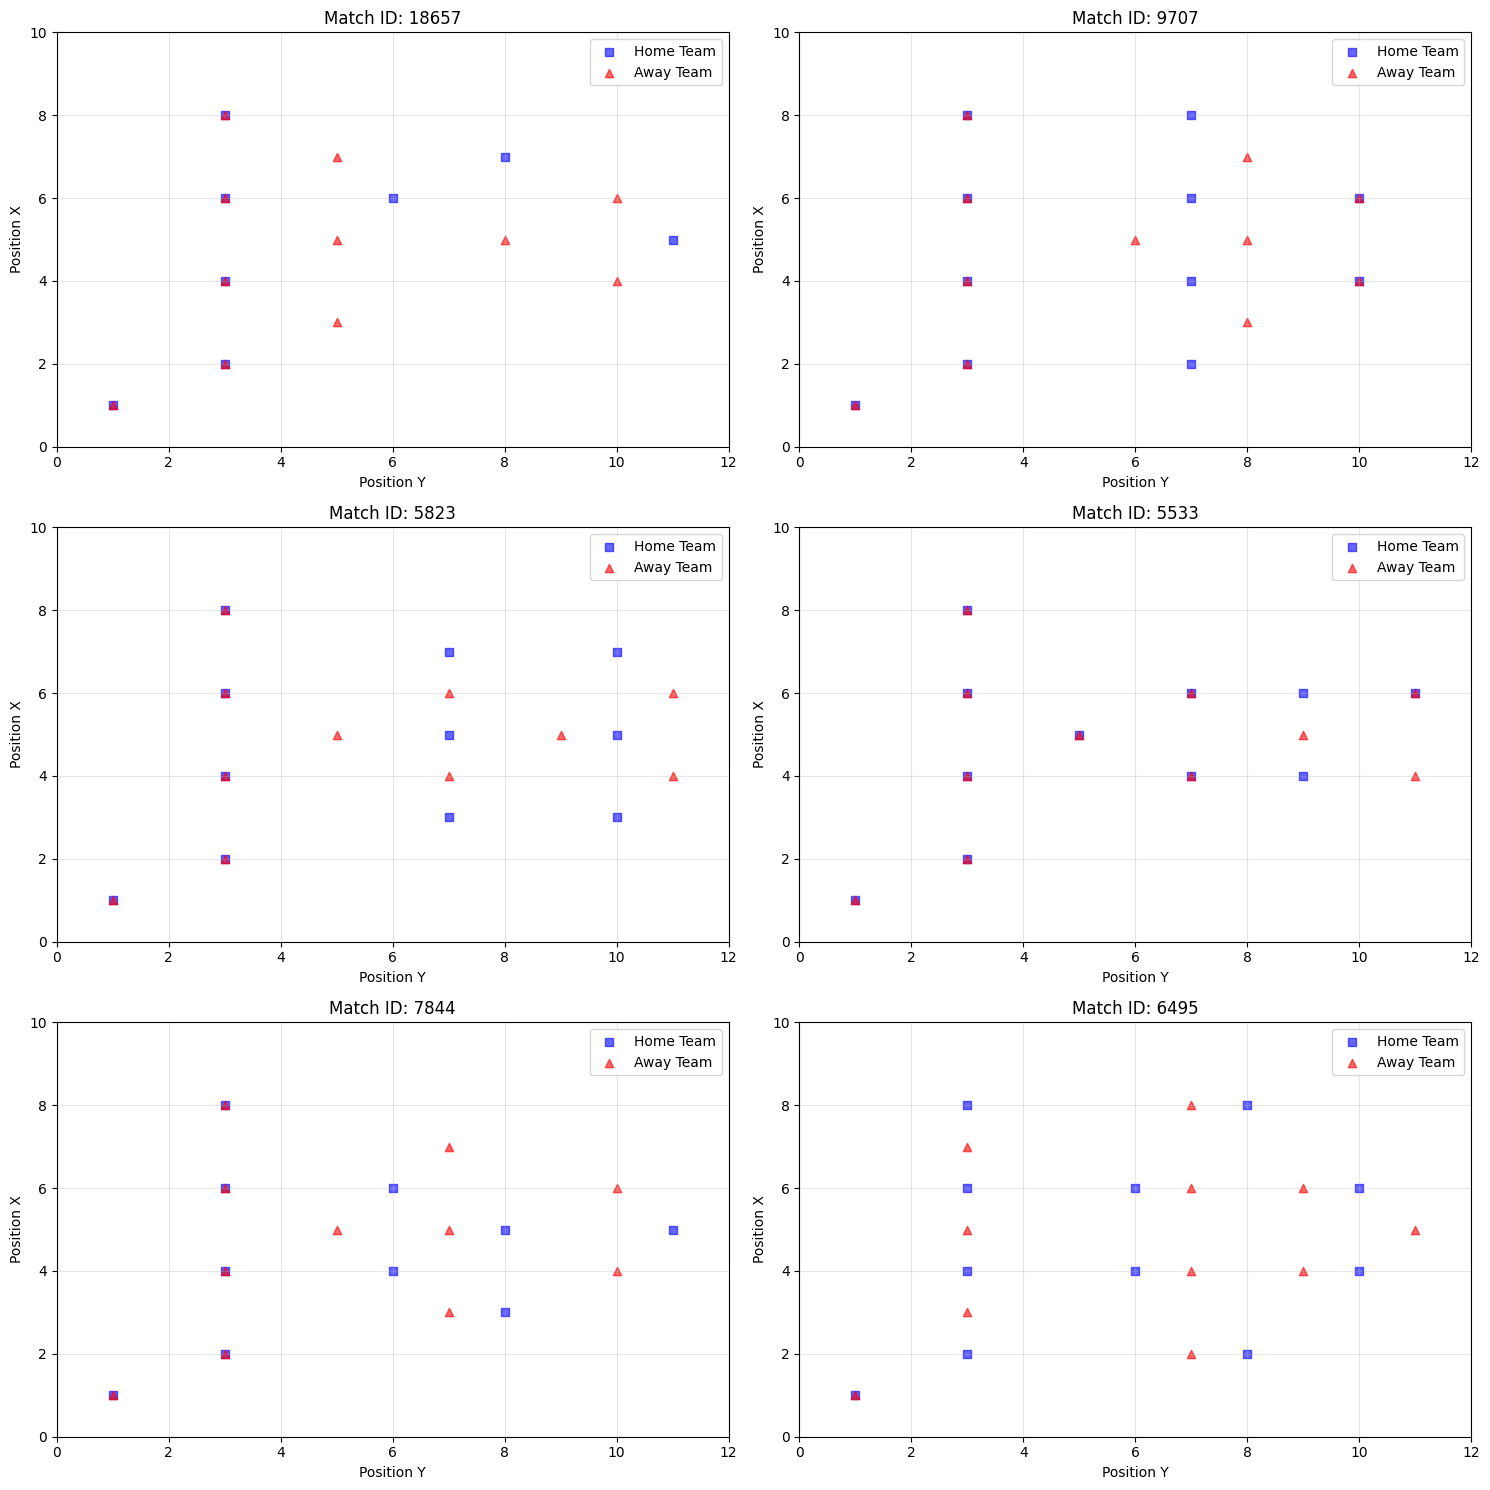

In [118]:
# Match player positions in graph 

player_match_df_copy = player_match_df.copy()

# Get a sample of matches to plot (e.g., first 4 matches)
sample_matches = player_match_df_copy.groupby('match_id')
# Get unique position combinations for each match
position_summary = player_match_df_copy.groupby('match_id').agg({
    'position_x': lambda x: tuple(sorted(x)),
    'position_y': lambda x: tuple(sorted(x))
}).reset_index()

# Find matches with different position patterns
different_position_matches = position_summary.drop_duplicates(subset=['position_x', 'position_y'])

# Get first 4 matches with different position patterns
sample_match_ids = different_position_matches['match_id'].sample(6)

# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.ravel()

# Plot each match's player positions
for idx, match_id in enumerate(sample_match_ids):
    match_positions = player_match_df[player_match_df['match_id'] == match_id]
    
    # Create scatter plot for this match
    axes[idx].scatter(match_positions[match_positions['team'] == 'home']['position_y'],
                     match_positions[match_positions['team'] == 'home']['position_x'],
                     marker='s', c='blue', label='Home Team', alpha=0.6)
    axes[idx].scatter(match_positions[match_positions['team'] == 'away']['position_y'],
                     match_positions[match_positions['team'] == 'away']['position_x'],
                     marker='^', c='red', label='Away Team', alpha=0.6)
    
    # Customize the subplot
    axes[idx].set_title(f'Match ID: {match_id}')
    axes[idx].set_xlabel('Position Y')
    axes[idx].set_ylabel('Position X')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim(0, 12)
    axes[idx].set_ylim(0, 10)
    axes[idx].legend()

plt.tight_layout()
plt.show()

In [120]:
# Convert xy to position name
def get_position_name(x, y):
    # Define regions for positions
    # Goalkeeper
    if x < 2 and y < 2:
        return "GK"  # Goalkeeper

    # Defense line
    if 2 <= y < 4:
        if x < 4:  # Left side
            return "RB"  # Left Back
        elif 4 <= x < 6:  # Center
            return "CB"  # Center Back
        else:  # Right side
            return "LB"  # Right Back

    # Midfield line
    if 4 <= y < 9:
        if x < 4:  # Left side
            return "RM"  # Left Midfielder
        elif 4 <= x < 6:  # Center
            return "CM"  # Central Midfielder
        else:  # Right side
            return "LM"  # Right Midfielder

    # Forward line
    if y >= 9:
        if x < 4:  # Left side
            return "RW"  # Left Wing
        elif 4 <= x < 6:  # Center
            return "CF"  # Center Forward
        else:  # Right side
            return "LW"  # Right Wing

    # Default fallback
    return "Unknown"

player_match_df['position_name'] = player_match_df[['position_x', 'position_y']].apply(
    lambda row: get_position_name(row['position_x'], row['position_y']), axis=1)
# Check the unique position names
player_match_df['position_name'].unique()

array(['GK', 'RB', 'CB', 'LB', 'CM', 'LM', 'RM', 'CF', 'RW', 'LW'],
      dtype=object)

In [121]:
player_match_df['position_name_code'] = player_match_df['position_name'].astype('category').cat.codes
player_match_df['position_name_code'].unique()

array([3, 7, 0, 4, 2, 5, 8, 1, 9, 6], dtype=int8)

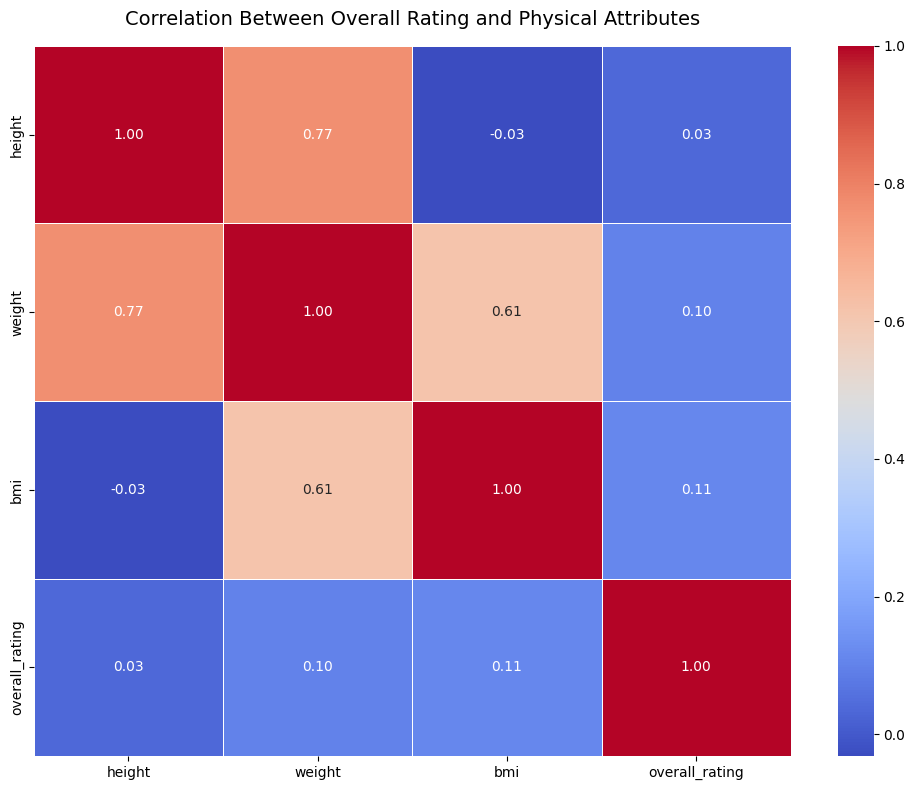

In [122]:
# Plot correlation matrix of player positions and physical attributes
position_physical_df = player_match_df[['height', 'weight', 'bmi', 'overall_rating']]

# Create correlation matrix
corr_matrix = position_physical_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Between Overall Rating and Physical Attributes', fontsize=14, pad=15)
plt.tight_layout()
plt.show()


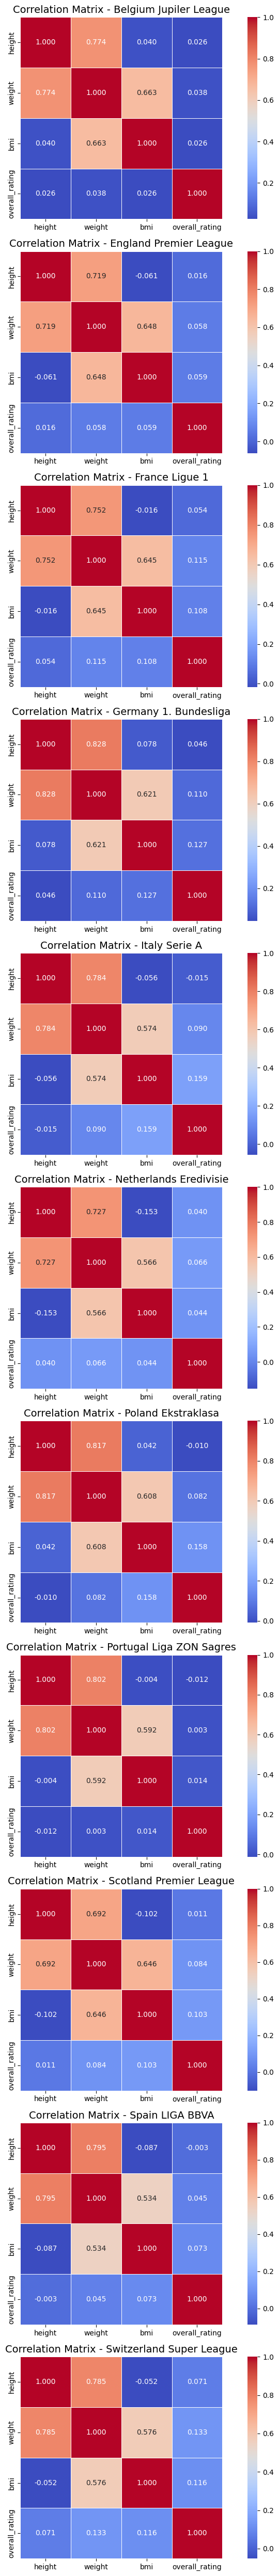

In [123]:
# Plot correlation matrices for specific leagues
# Select major leagues for analysis
major_leagues = player_match_df['league_name'].unique()

# Create a figure with subplots for each league
fig, axes = plt.subplots(len(major_leagues), 1, figsize=(10, 50))

# For each league, create a correlation matrix and plot it
for i, league in enumerate(major_leagues):
    # Filter data for this league
    league_df = player_match_df[player_match_df['league_name'] == league]
    
    # If we have data for this league, create correlation matrix
    if not league_df.empty:
        # Extract the relevant columns
        league_data = league_df[['height', 'weight', 'bmi', 'overall_rating']]
        
        # Create correlation matrix
        corr = league_data.corr()
        
        # Plot heatmap
        sns.heatmap(corr, annot=True, fmt='.3f', cmap='coolwarm', 
                   linewidths=0.5, ax=axes[i], square=True)
        
        # Add title
        axes[i].set_title(f'Correlation Matrix - {league}', fontsize=14)
    else:
        # If no data for this league, display a message
        axes[i].text(0.5, 0.5, f'No data available for {league}', 
                    horizontalalignment='center', fontsize=14)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

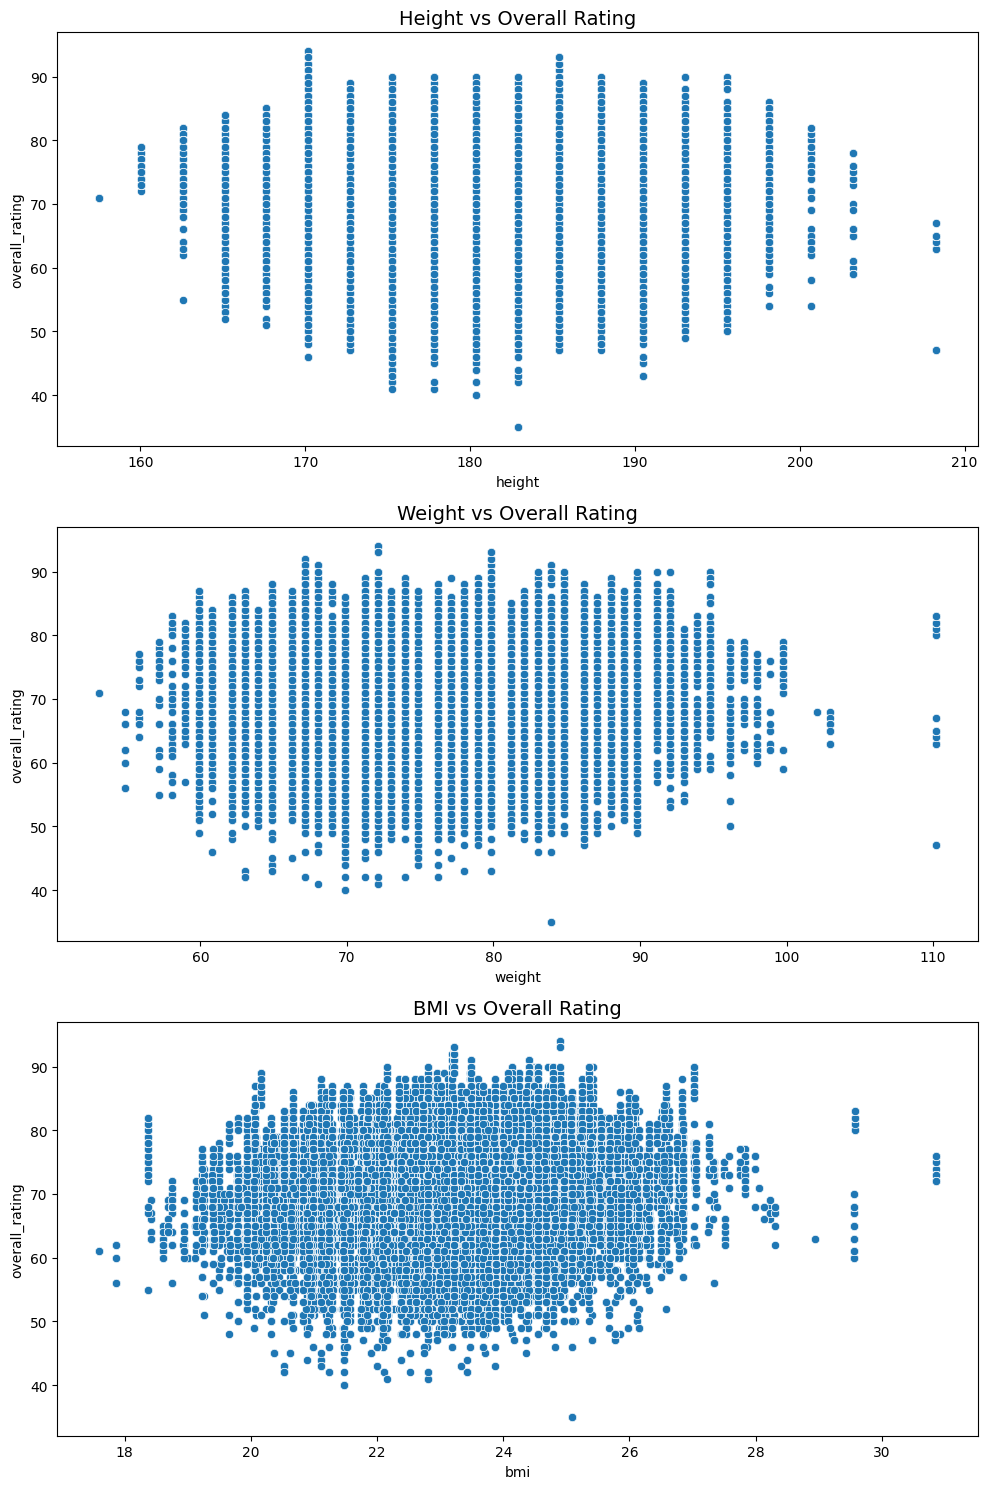

In [126]:
# Plot a scatter plot of height vs overall rating, weight vs overall rating, and bmi vs overall rating

fig, axes = plt.subplots(3, 1, figsize=(10, 15))
sns.scatterplot(data=player_match_df, x='height', y='overall_rating', ax=axes[0])
axes[0].set_title('Height vs Overall Rating', fontsize=14)
sns.scatterplot(data=player_match_df, x='weight', y='overall_rating', ax=axes[1])
axes[1].set_title('Weight vs Overall Rating', fontsize=14)
sns.scatterplot(data=player_match_df, x='bmi', y='overall_rating', ax=axes[2])
axes[2].set_title('BMI vs Overall Rating', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Create more detailed analysis with boxplots
plt.figure(figsize=(15, 10))

# Create a subplot for each physical attribute
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Map position codes to names for better readability
position_map = {code: name for code, name in zip(
    player_match_df['position_name_code'].unique(),
    player_match_df['position_name'].unique()
)}

# Boxplot for height by position
sns.boxplot(x='position_name', y='height', data=player_match_df, ax=axes[0])
axes[0].set_title('Height by Position', fontsize=14)
axes[0].set_xlabel('Position', fontsize=12)
axes[0].set_ylabel('Height (cm)', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

# Boxplot for weight by position
sns.boxplot(x='position_name', y='weight', data=player_match_df, ax=axes[1])
axes[1].set_title('Weight by Position', fontsize=14)
axes[1].set_xlabel('Position', fontsize=12)
axes[1].set_ylabel('Weight (kg)', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

# Boxplot for BMI by position
sns.boxplot(x='position_name', y='bmi', data=player_match_df, ax=axes[2])
axes[2].set_title('BMI by Position', fontsize=14)
axes[2].set_xlabel('Position', fontsize=12)
axes[2].set_ylabel('BMI', fontsize=12)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

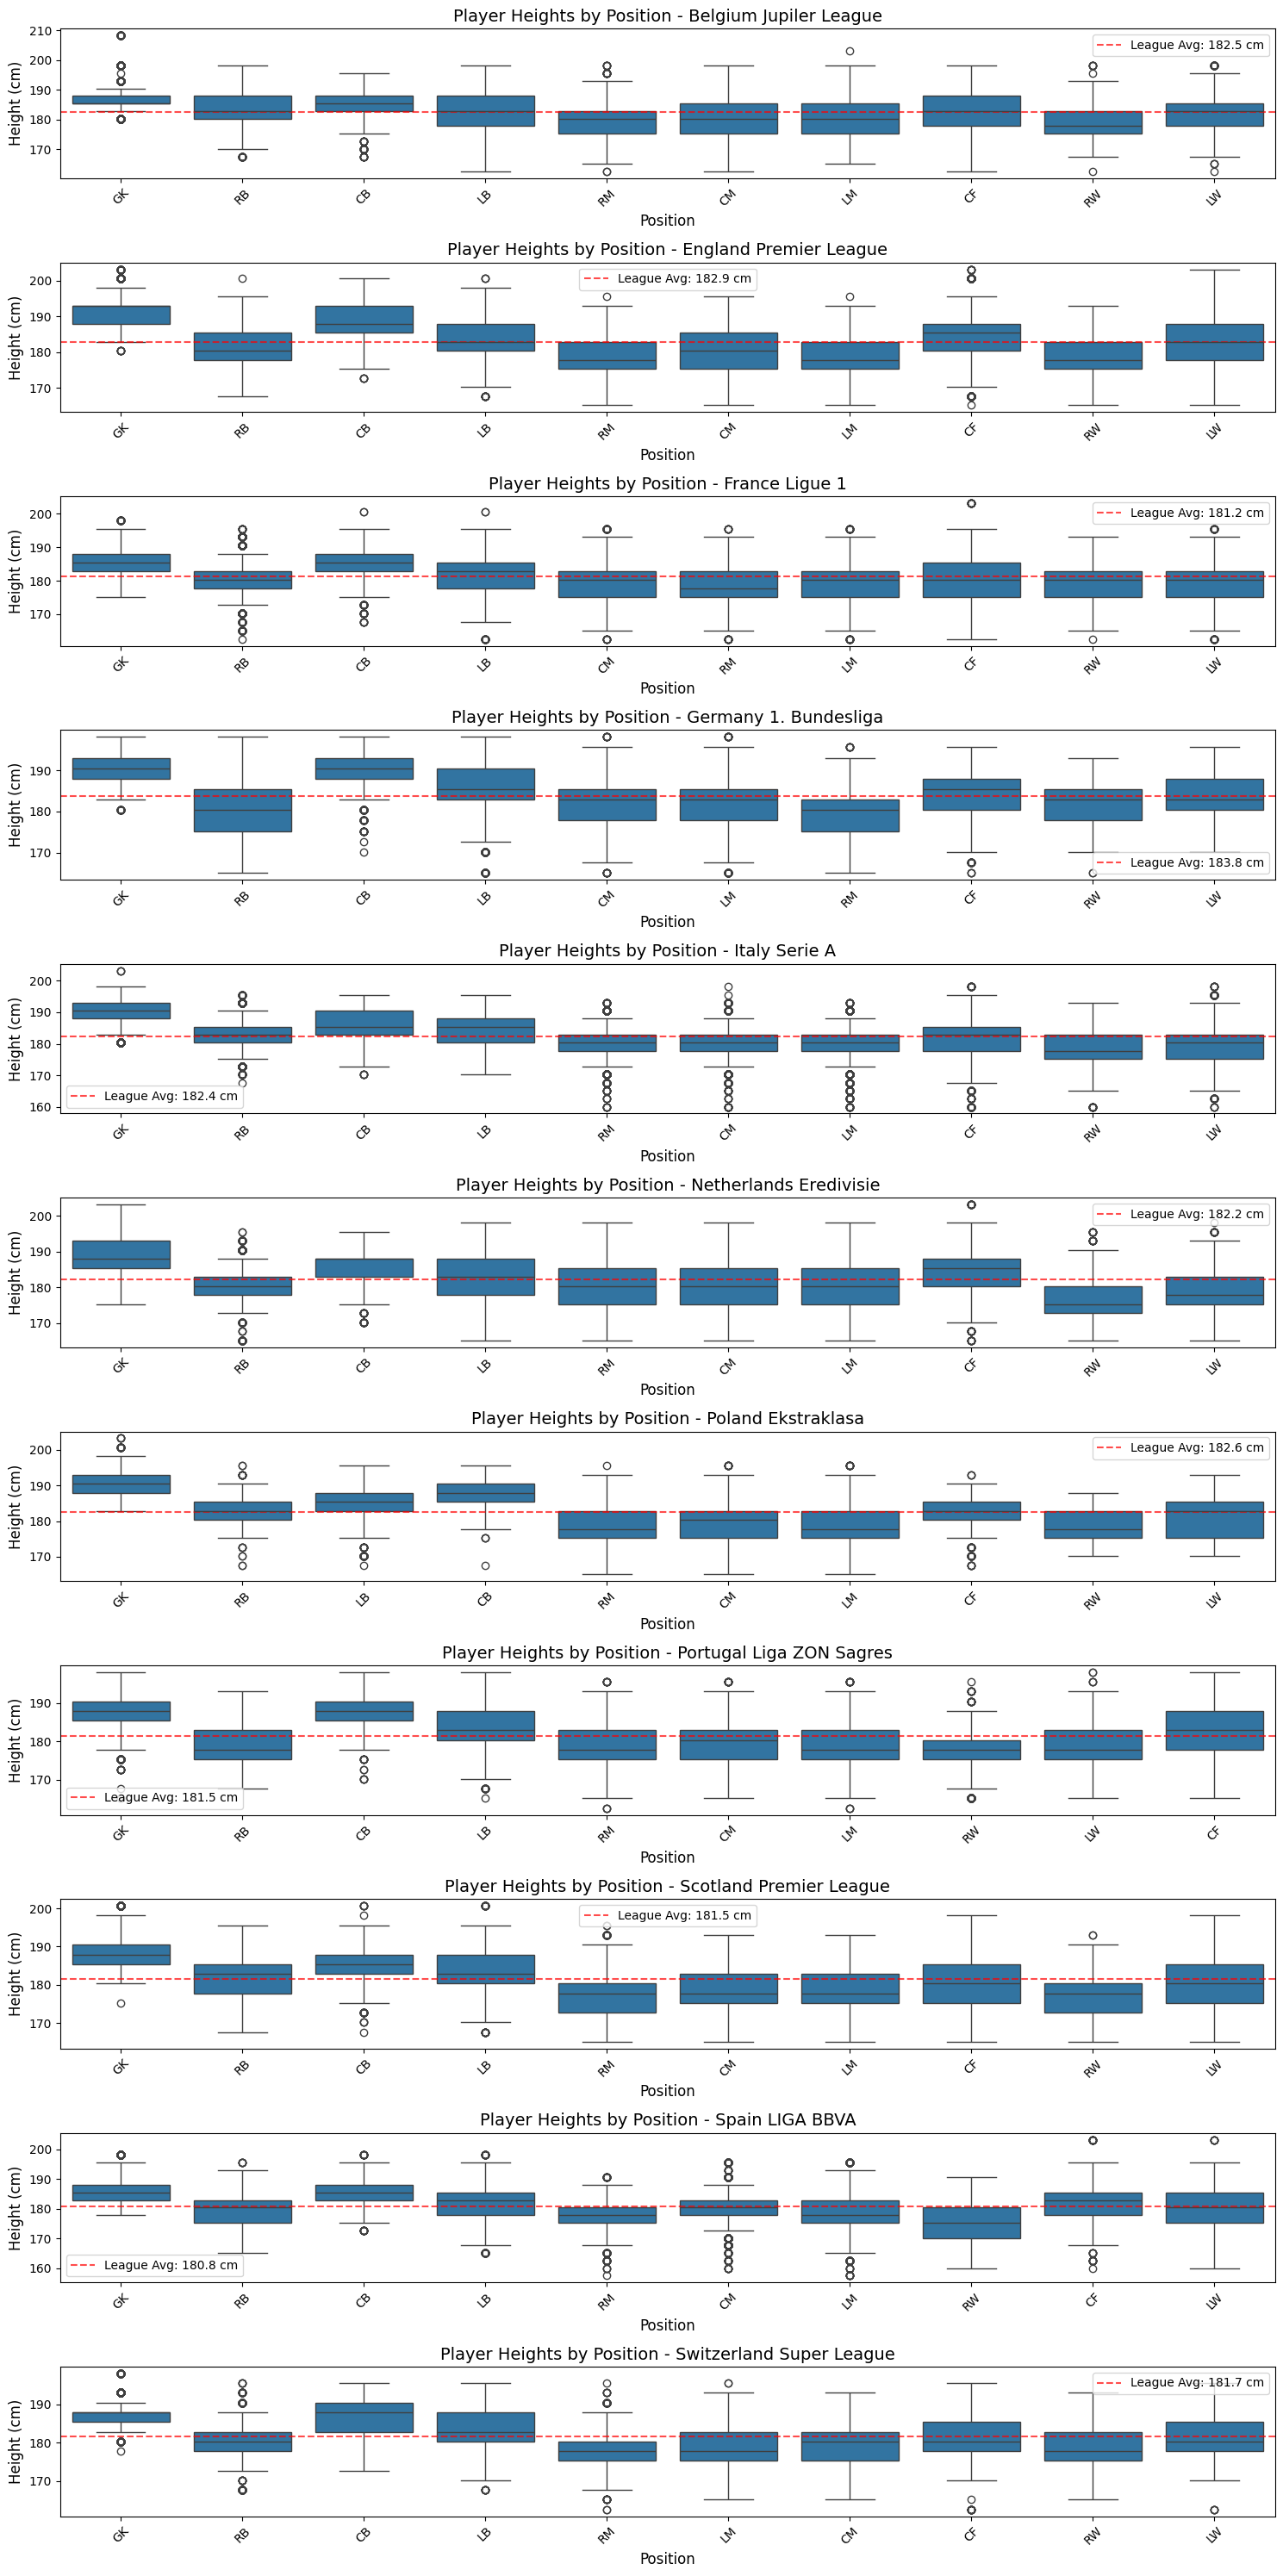

In [124]:
# Create boxplots comparing player heights across positions for each league
fig, axes = plt.subplots(len(major_leagues), 1, figsize=(15, 30))

for i, league in enumerate(major_leagues):
    # Filter data for this league
    league_df = player_match_df[player_match_df['league_name'] == league]

    if not league_df.empty:
        # Create boxplot
        sns.boxplot(x='position_name', y='height', data=league_df, ax=axes[i])

        # Add title and labels
        axes[i].set_title(
            f'Player Heights by Position - {league}', fontsize=14)
        axes[i].set_xlabel('Position', fontsize=12)
        axes[i].set_ylabel('Height (cm)', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

        # Add league average line
        avg_height = league_df['height'].mean()
        axes[i].axhline(avg_height, color='red', linestyle='--',
                        alpha=0.7, label=f'League Avg: {avg_height:.1f} cm')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'No data available for {league}',
                     horizontalalignment='center', fontsize=14)
        axes[i].axis('off')

plt.tight_layout()
plt.show()


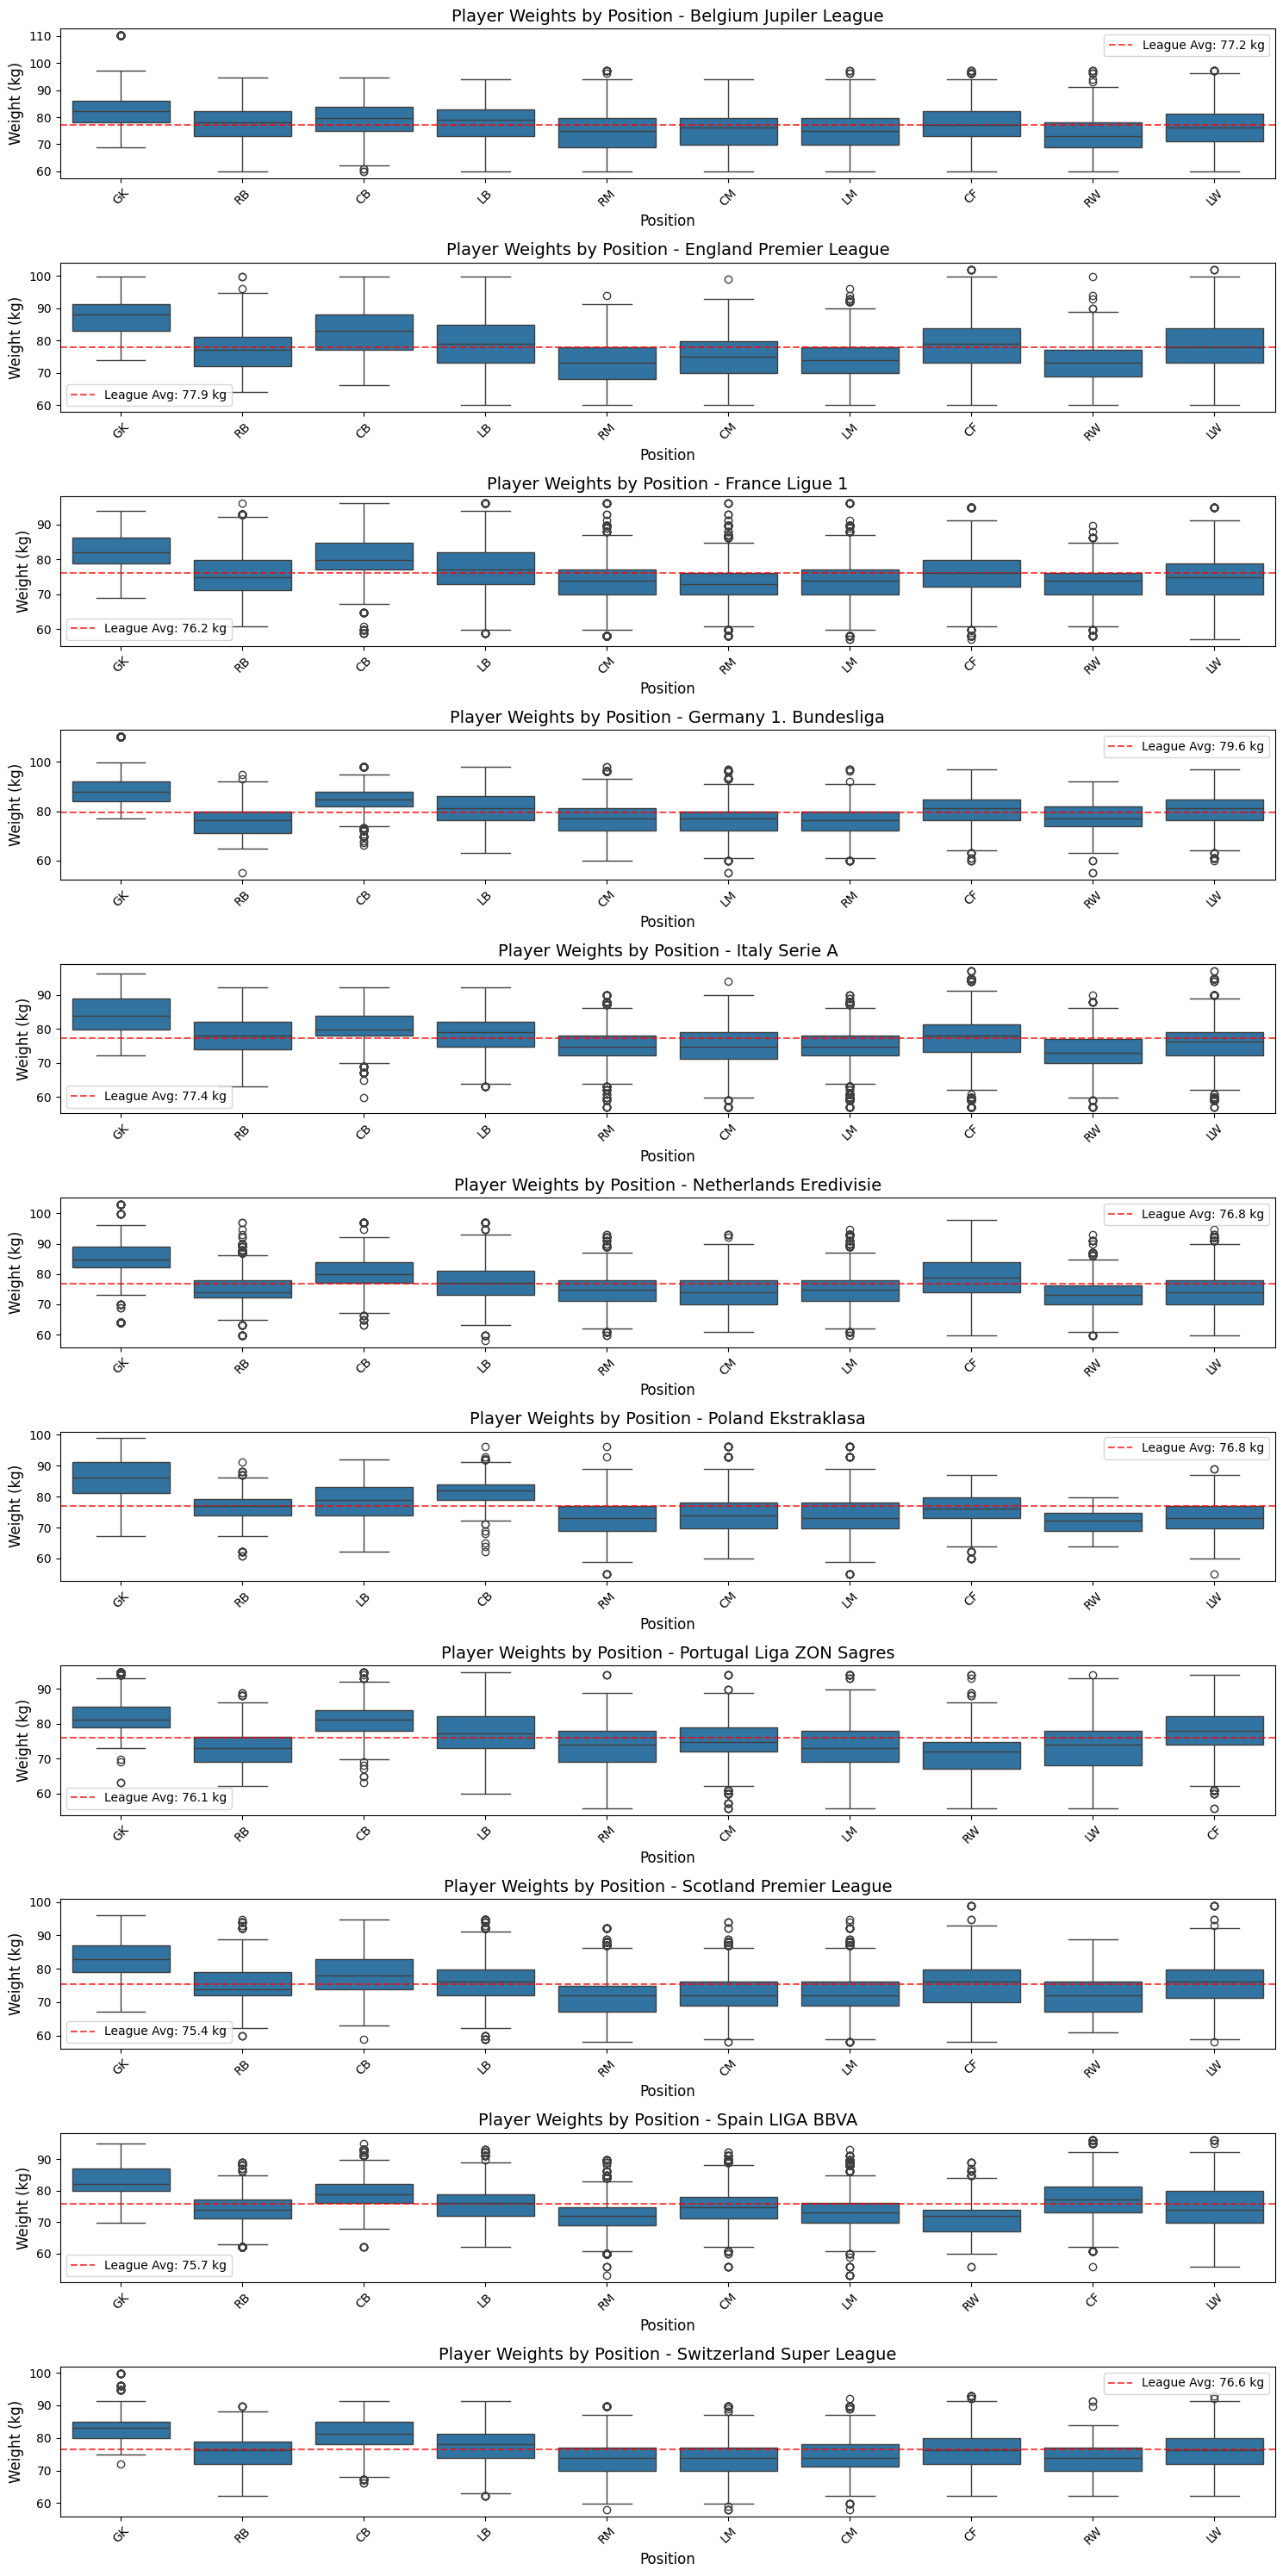

In [125]:
# Create boxplots comparing player weights across positions for each league
fig, axes = plt.subplots(len(major_leagues), 1, figsize=(15, 30))

for i, league in enumerate(major_leagues):
    # Filter data for this league
    league_df = player_match_df[player_match_df['league_name'] == league]

    if not league_df.empty:
        # Create boxplot
        sns.boxplot(x='position_name', y='weight', data=league_df, ax=axes[i])

        # Add title and labels
        axes[i].set_title(
            f'Player Weights by Position - {league}', fontsize=14)
        axes[i].set_xlabel('Position', fontsize=12)
        axes[i].set_ylabel('Weight (kg)', fontsize=12)
        axes[i].tick_params(axis='x', rotation=45)

        # Add league average line
        avg_weight = league_df['weight'].mean()
        axes[i].axhline(avg_weight, color='red', linestyle='--',
                        alpha=0.7, label=f'League Avg: {avg_weight:.1f} kg')
        axes[i].legend()
    else:
        axes[i].text(0.5, 0.5, f'No data available for {league}',
                     horizontalalignment='center', fontsize=14)
        axes[i].axis('off')
plt.tight_layout()
plt.show()
